In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
DATA_STORE = '../data/assets.h5'
START = 2000
END = 2018

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [6]:
stocks = stocks[~stocks.index.duplicated()] #索引内部去重
stocks.index.name = 'ticker'

In [7]:
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [8]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [9]:
assert prices.shape[1] == stocks.shape[0]

In [10]:
monthly_prices = prices.resample('M').last()

In [11]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()

In [12]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
data = data.loc[idx[keep,:], :]
keep

Index(['A', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ABC', 'ABCB',
       ...
       'YORW', 'YRCW', 'YUM', 'ZBH', 'ZBRA', 'ZEUS', 'ZION', 'ZIOP', 'ZIXI',
       'ZUMZ'],
      dtype='object', name='ticker', length=1838)

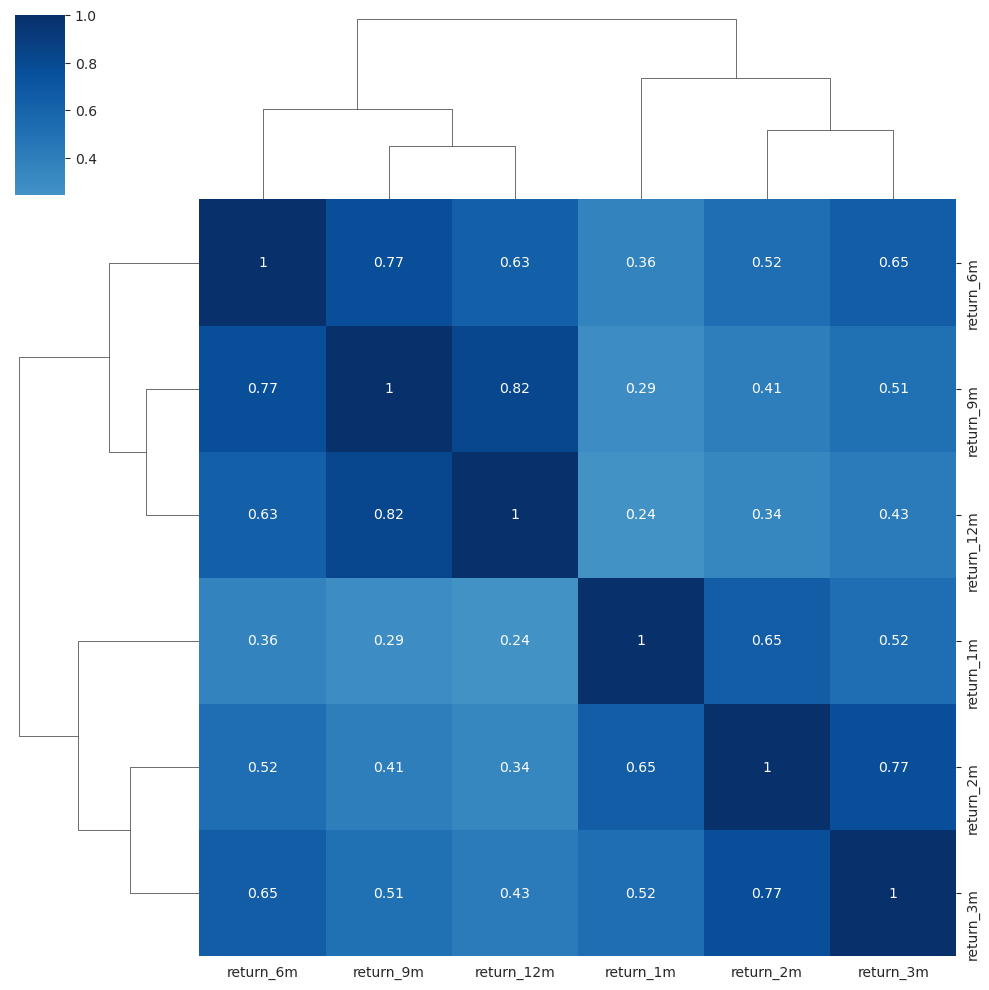

In [13]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [14]:
data.index.get_level_values('ticker').nunique()

1838

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
#a = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2000-01-31 to 2023-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  288 non-null    float64
 1   SMB     288 non-null    float64
 2   HML     288 non-null    float64
 3   RMW     288 non-null    float64
 4   CMA     288 non-null    float64
dtypes: float64(5)
memory usage: 13.5 KB


In [16]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [18]:
T = 24
betas = (factor_data.groupby(level='ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))
betas.info()
betas.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Mkt-RF  318478 non-null  float64
 1   SMB     318478 non-null  float64
 2   HML     318478 non-null  float64
 3   RMW     318478 non-null  float64
 4   CMA     318478 non-null  float64
dtypes: float64(5)
memory usage: 15.2+ MB


Mkt-RF  SMB  HML  RMW  CMA
ticker date                                  
A      2001-01-31     NaN  NaN  NaN  NaN  NaN
       2001-02-28     NaN  NaN  NaN  NaN  NaN
       2001-03-31     NaN  NaN  NaN  NaN  NaN
       2001-04-30     NaN  NaN  NaN  NaN  NaN
       2001-05-31     NaN  NaN  NaN  NaN  NaN

In [19]:
b = (factor_data.groupby(level='ticker', group_keys=False)
                .apply(lambda x: sm.OLS(x.return_1m, sm.add_constant(x.drop(columns=['return_1m'])))
                       .fit().params))
b.info()
b.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1838 entries, A to ZUMZ
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   const   1838 non-null   float64
 1   Mkt-RF  1838 non-null   float64
 2   SMB     1838 non-null   float64
 3   HML     1838 non-null   float64
 4   RMW     1838 non-null   float64
 5   CMA     1838 non-null   float64
dtypes: float64(6)
memory usage: 100.5+ KB


,const,Mkt-RF,SMB,HML,RMW,CMA
ticker,,,,,,
A,0.003636,1.411417,0.424784,-0.942771,-1.103024,0.883472
AAL,0.006525,0.700104,1.713808,0.416819,0.273905,1.479392
AAN,0.005568,0.650767,1.166506,0.071701,0.871402,0.012268
AAON,0.010639,0.900291,1.023998,-0.060400,0.357448,0.165164
AAP,0.003158,0.897691,0.676155,-0.639719,0.820081,0.841857


In [23]:
betas.tail(3)
#c = betas.groupby(level='ticker').shift()
#c.info()
#c.head()

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
ZUMZ   2018-01-31  0.065406  1.156550  1.321246  2.979204  0.647188
       2018-02-28  0.326675  1.020393  1.345950  2.712224  0.680867
       2018-03-31  0.224885  1.651891  1.167755  2.936886  0.541205

In [24]:
c = betas.groupby(level='ticker').shift()
c.tail(3)

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
ZUMZ   2018-01-31 -0.970033  1.658541  1.531017  3.655010  0.334506
       2018-02-28  0.065406  1.156550  1.321246  2.979204  0.647188
       2018-03-31  0.326675  1.020393  1.345950  2.712224  0.680867

In [25]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.979365,0.626588,0.122610,-0.062073,0.016754,1.485997
std,0.918116,1.254249,1.603524,1.908446,2.158982,3.306487
min,-9.805604,-10.407516,-15.382504,-23.159702,-18.406854,-33.499590
25%,0.463725,-0.118767,-0.707780,-0.973586,-1.071697,0.000000
50%,0.928902,0.541623,0.095292,0.037585,0.040641,1.213499
75%,1.444882,1.304325,0.946760,0.950267,1.135600,3.147199
max,10.855709,10.297453,15.038572,17.079472,16.671709,34.259432


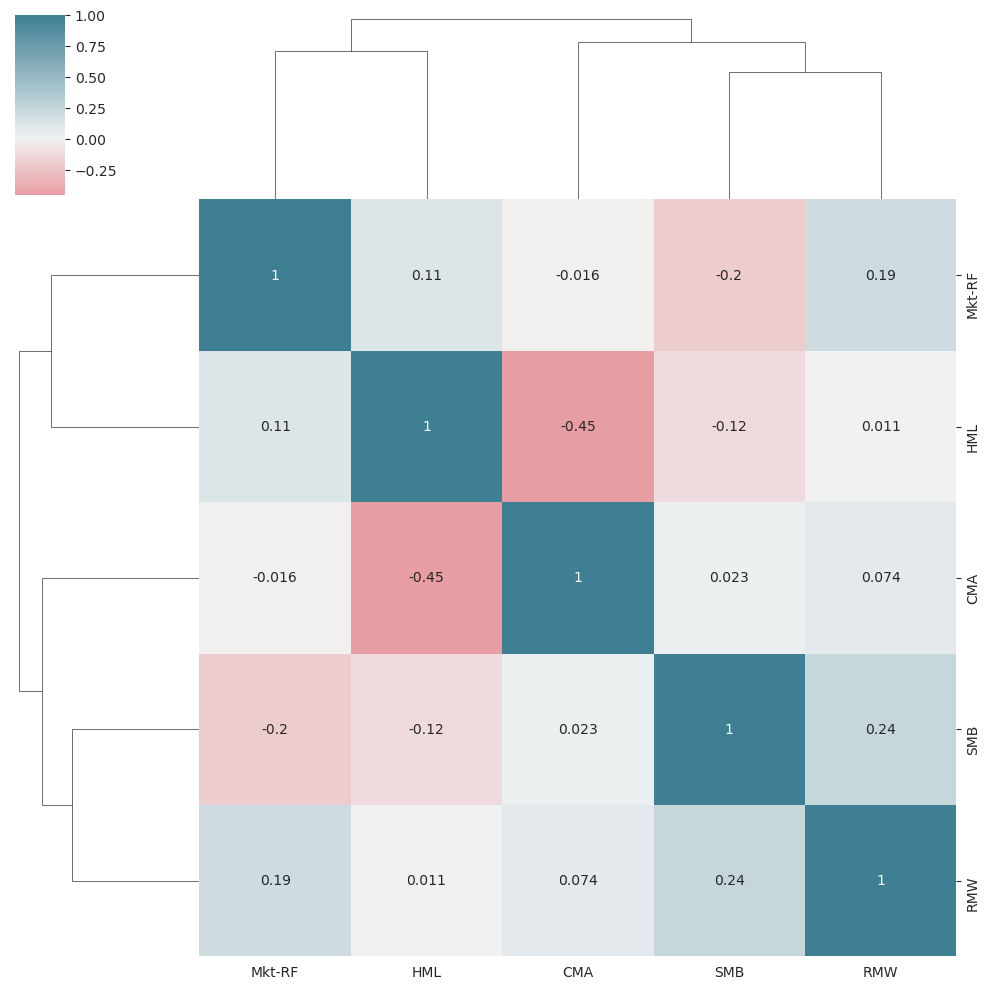

In [26]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

In [27]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


In [28]:
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


In [29]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [30]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [31]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non-null  float64
 16  

In [32]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [33]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non-null  float64
 16  

In [35]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6))) 
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

In [36]:
monthly_prices.info()
monthly_prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN


In [37]:
d = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               )
d.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.070564,1.001290,0.884873,0.990476,1.023982,0.939984,0.924404,1.074696,1.047394,1.007526,...,1.126335,1.831422,1.039445,1.093505,0.891559,1.034621,0.982900,1.057641,1.044444,1.053299
2017-12-31,0.912025,0.957842,0.974566,1.008242,0.852124,1.010751,1.042667,0.691137,0.921240,0.900093,...,1.071090,0.900438,0.964771,0.949261,0.842806,0.921922,0.940774,1.049430,1.035461,1.003614
2017-11-30,1.033896,0.970402,0.946550,0.993188,1.013141,1.015482,0.984655,0.984249,0.923764,1.029046,...,1.095870,0.856745,1.022791,0.970415,1.062813,0.926943,0.974818,1.103865,1.004566,1.046819


In [38]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.095970,1.067191,0.900264,0.957895,1.017216,0.994594,0.952583,1.027240,1.186406,1.020000,...,1.027597,1.876616,1.008464,1.171829,0.909198,1.151111,1.038639,0.974074,0.963554,0.879237
2017-12-31,0.999552,1.022200,0.877367,0.965789,0.866794,1.005287,0.993226,0.709964,1.092965,0.918095,...,1.100649,1.689777,0.972938,1.112371,0.766278,1.061235,0.977124,1.022222,0.997722,0.882415
2017-11-30,1.033433,0.991945,0.830471,0.959211,0.878185,1.020851,0.977985,0.698781,1.009642,0.944762,...,1.206169,1.447709,0.995112,1.079462,0.814410,0.983704,0.952518,1.128395,1.002278,0.923729


In [39]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')
msize.head()

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.960000e+10,1.767000e+10,3.200000e+09,1.810000e+09,9.990000e+09,9.039900e+11,1.830000e+09,1.900000e+09,1.905000e+10,2.160000e+09,...,4.268100e+08,3.429500e+08,2.516000e+10,2.275000e+10,7.920000e+09,2.295400e+08,1.032000e+10,4.357400e+08,2.944800e+08,6.316500e+08
2018-02-28,2.006513e+10,1.883296e+10,3.255658e+09,1.750461e+09,9.923985e+09,9.565088e+11,1.885783e+09,1.816100e+09,2.157836e+10,2.186743e+09,...,3.893948e+08,3.514129e+08,2.441012e+10,2.437949e+10,8.076693e+09,2.553845e+08,1.090524e+10,4.013112e+08,2.716729e+08,5.272672e+08
2018-01-31,2.148101e+10,1.885726e+10,2.880845e+09,1.733789e+09,1.016199e+10,8.991033e+11,1.743226e+09,1.951756e+09,2.260104e+10,2.203200e+09,...,4.385888e+08,6.435854e+08,2.537297e+10,2.665911e+10,7.200850e+09,2.642260e+08,1.071875e+10,4.244430e+08,2.837472e+08,5.553702e+08
2017-12-31,1.959122e+10,1.806228e+10,2.807574e+09,1.748079e+09,8.659274e+09,9.087693e+11,1.817604e+09,1.348932e+09,2.082099e+10,1.983086e+09,...,4.697681e+08,5.795089e+08,2.447911e+10,2.530644e+10,6.068921e+09,2.435958e+08,1.008392e+10,4.454231e+08,2.938092e+08,5.573776e+08
2017-11-30,2.025528e+10,1.752767e+10,2.657508e+09,1.736171e+09,8.773063e+09,9.228388e+11,1.789712e+09,1.327685e+09,1.923367e+10,2.040686e+09,...,5.148049e+08,4.964917e+08,2.503702e+10,2.455775e+10,6.450128e+09,2.257993e+08,9.829988e+09,4.916869e+08,2.951508e+08,5.834733e+08


In [43]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()  ## 单index变multi_index
                 .swaplevel())  ## 交换multi_index主次顺序
data.msize = data.msize.fillna(-1)

In [44]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [45]:
#get_dummies：指定整型列变one hot编码，该部分数据默认inplace操作；其他列保持不变
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
 13  momentum_6     

In [47]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
#pd.set_option('display.max_rows', None)
#显示宽度无限长
#pd.set_option('display.width', None)
dummy_data.head()

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.264316  0.573533 -0.673074 -1.252138   
       2001-02-28   -0.084537  1.264316  0.573533 -0.673074 -1.252138   
       2001-03-31   -0.096606  1.264316  0.573533 -0.673074 -1.252138   
       2001-04-30   -0.066102  1.264316  0.573533 -0.673074 -1.252138   
       2001-05-31   -0.063425  1.264316  0.573533 -0.673074 -1.252138   

                       CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                  
A      2001-01-31  0.69929    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.69929    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.69929   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.69929   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.69929    0.184941    0.116903    0.069178    0.075921   

                   momentum_12  momentum_3_12  return_1m_t-1  return_1m_t-2  \
ticker date                                                                   
A      2001-01-31    -0.012335      -0.072092            NaN            NaN   
       2001-02-28     0.245026       0.031898      -0.003653            NaN   
       2001-03-31     0.049783       0.078511      -0.329564      -0.003653   
       2001-04-30    -0.335545       0.039645      -0.146389      -0.329564   
       2001-05-31     0.076795      -0.040108       0.269444      -0.146389   

                   return_1m_t-3  return_1m_t-4  return_1m_t-5  return_1m_t-6  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31            NaN            NaN            NaN            NaN   
       2001-04-30      -0.003653            NaN            NaN            NaN   
       2001-05-31      -0.329564      -0.003653            NaN            NaN   

                   target_1m  target_2m  target_3m  target_6m  target_12m  \
ticker date                                                                 
A      2001-01-31  -0.329564  -0.249443  -0.105747  -0.101978   -0.047686   
       2001-02-28  -0.146389   0.040966  -0.023317  -0.049781   -0.011986   
       2001-03-31   0.269444   0.044721   0.018842  -0.072607    0.010805   
       2001-04-30  -0.140220  -0.087246  -0.098192  -0.089198   -0.021512   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.033904   -0.019843   

                   year_2001  year_2002  year_2003  year_2004  year_2005  \
ticker date                                                                
A      2001-01-31       True      False      False      False      False   
       2001-02-28       True      False      False      False      False   
       2001-03-31       True      False      False      False      False   
       2001-04-30       True      False      False      False      False   
       2001-05-31       True      False      False      False      False   

                   year_2006  year_2007  year_2008  year_2009  year_2010  \
ticker date                                                                
A      2001-01-31      False      False      False      False      False   
    